In [2]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
# using JD as its not as stable
df_g = yf.download('GOOGL', start='2015-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
print(df_g)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-07-01   27.183001   27.290501   26.988001   27.165001   27.165001   
2015-07-02   27.237000   27.400000   27.178499   27.367001   27.367001   
2015-07-06   27.112499   27.429001   27.105000   27.281000   27.281000   
2015-07-07   27.371500   27.549999   26.992500   27.501499   27.501499   
2015-07-08   27.280001   27.414000   27.059999   27.084999   27.084999   
...                ...         ...         ...         ...         ...   
2023-06-26  120.760002  122.000000  118.269997  118.339996  118.339996   
2023-06-27  117.080002  119.080002  116.099998  118.330002  118.330002   
2023-06-28  117.089996  120.389999  116.849998  120.180000  120.180000   
2023-06-29  119.239998  120.059998  118.300003  119.099998  119.099998   
2023-06-30  120.169998  121.080002  119.690002  119.699997  119.699997   

              Volume  
Date          

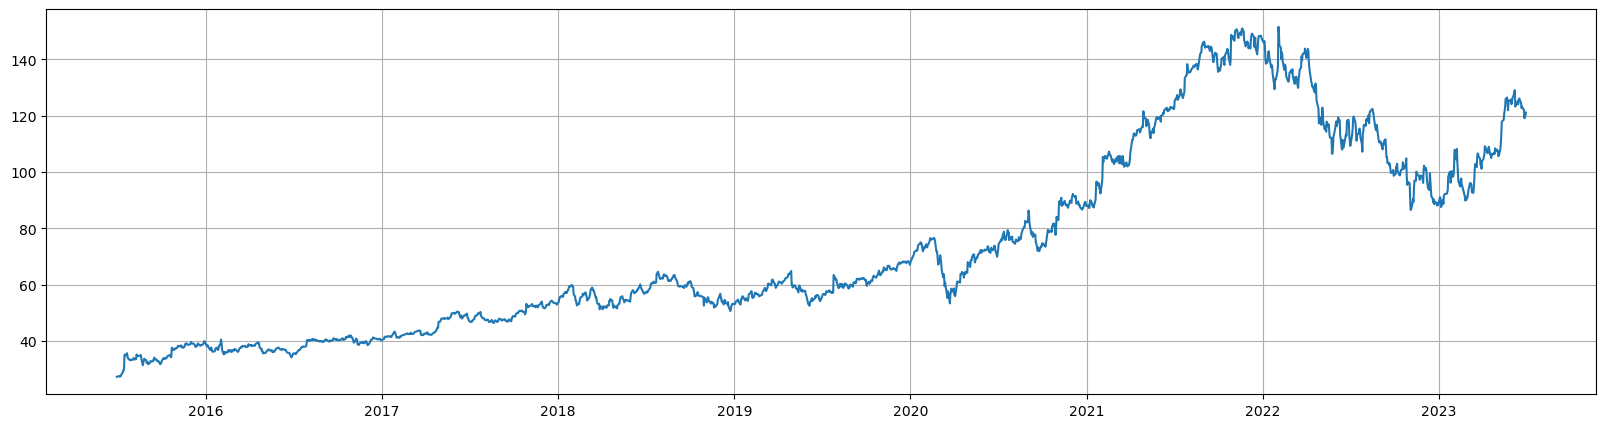

In [5]:
plt.figure(figsize=(20,5))
plt.plot(df_g.High)
plt.grid()

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing values
ser = df_g.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [7]:
int(series.shape[0]*0.9)

1812

In [8]:
# fixed input size to model, last 30 days
Window = 30
Predday = 7

# To split the data into 90:10
Trainsplit = 0.9

cut = int(series.shape[0]*Trainsplit)

# train
closetrain = series[:cut]
# test
closetest = series[cut:-(Window+Predday)]
# forecast for future 7 days
closeforecast = series[-(Window+Predday):]

closetrain.shape, closetest.shape , closeforecast.shape

((1812, 1), (165, 1), (37, 1))

In [9]:
def windowed_dataset(series, window_size = 31,predday = 7, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-7], tf.squeeze(w[-7:])))
    return ds.batch(batch_size).prefetch(3)

trainbatches =  windowed_dataset(closetrain)
testbatches =  windowed_dataset(closetest,batch_size=8)


In [10]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [11]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(7)
np.random.seed(7)

model = tf.keras.Sequential()
model.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model.add(layers.LSTM(j, return_sequences=True))
model.add(layers.LSTM(128))
for i in [64,64,7]:
    model.add(layers.Dense(i, activation="selu"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h = model.fit(trainbatches,epochs=100,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/100
56/56 [==============================] - 8s 71ms/step - loss: 0.0011 - mse: 0.0022 - val_loss: 9.4447e-04 - val_mse: 0.0019
Epoch 2/100
56/56 [==============================] - 3s 55ms/step - loss: 3.8160e-04 - mse: 7.6320e-04 - val_loss: 8.4023e-04 - val_mse: 0.0017
Epoch 3/100
56/56 [==============================] - 3s 61ms/step - loss: 3.5715e-04 - mse: 7.1429e-04 - val_loss: 9.2715e-04 - val_mse: 0.0019
Epoch 4/100
56/56 [==============================] - 3s 52ms/step - loss: 3.3735e-04 - mse: 6.7471e-04 - val_loss: 8.1962e-04 - val_mse: 0.0016
Epoch 5/100
56/56 [==============================] - 5s 83ms/step - loss: 3.2951e-04 - mse: 6.5901e-04 - val_loss: 0.0013 - val_mse: 0.0027
Epoch 6/100
56/56 [==============================] - 4s 77ms/step - loss: 3.3340e-04 - mse: 6.6680e-04 - val_loss: 9.7981e-04 - val_mse: 0.0020
Epoch 7/100
56/56 [==============================] - 4s 77ms/step - loss: 5.2181e-04 - mse: 0.0010 - val_loss: 9.5448e-04 - val_mse: 0.0019
Epoch 8/

In [13]:
for t in hist.keys():
    print(t)

loss
mse
val_loss
val_mse


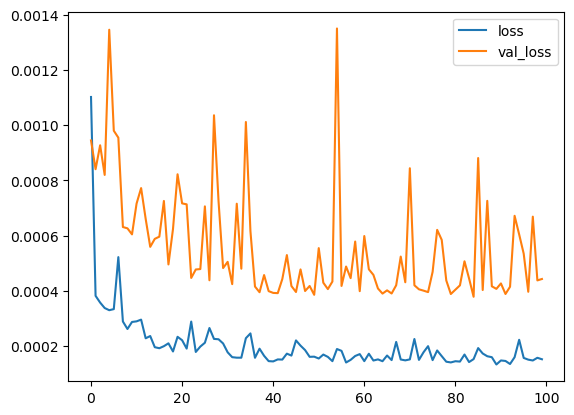

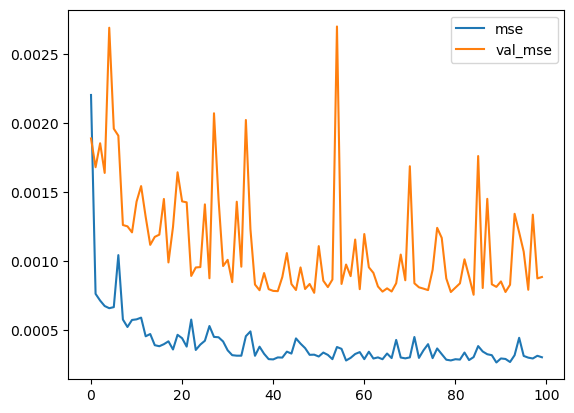

In [14]:
for i in ["loss","mse"]:
    plt.plot(hist[i],label = i)
    plt.plot(hist["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()


In [15]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

1/1 [==============================] - 1s 721ms/step


(8, 7)

In [16]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 26ms/step


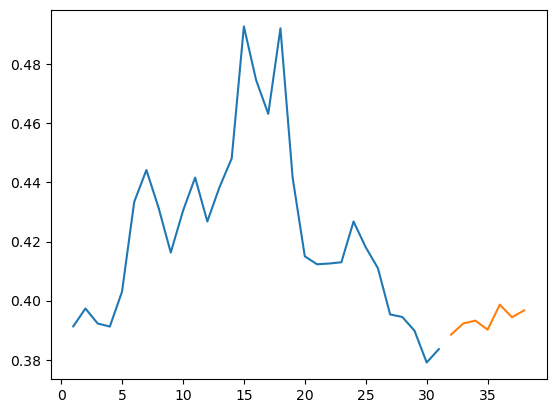

In [17]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)

time=list(range(1,32))
time2=list(range(32,39))
plt.plot(time,x1[0])
plt.plot(time2,output[0])

1/1 [==============================] - 0s 30ms/step


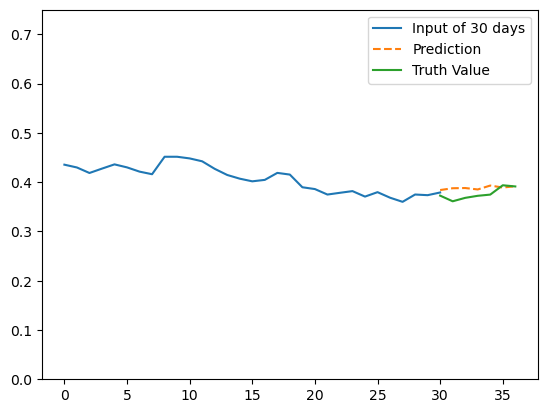

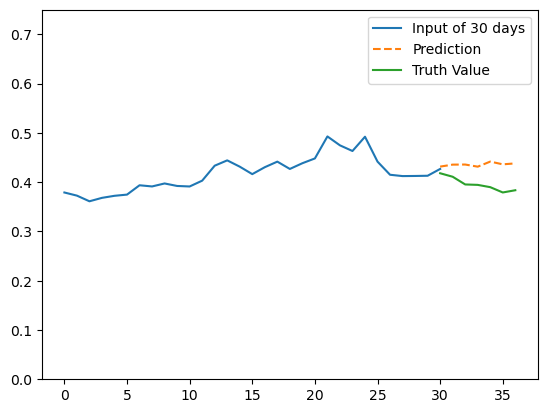

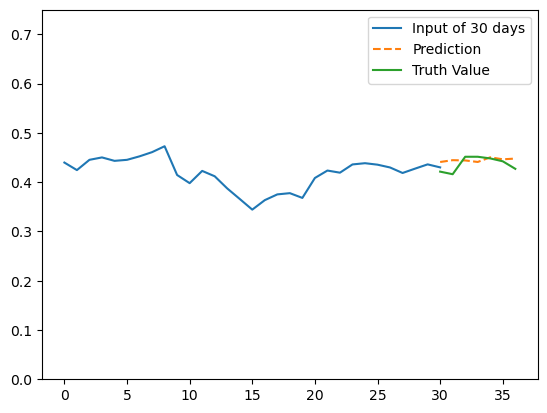

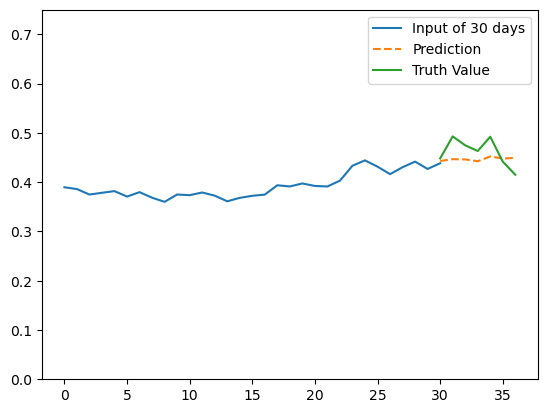

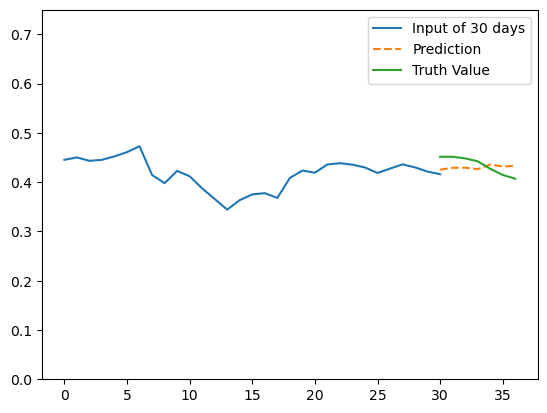

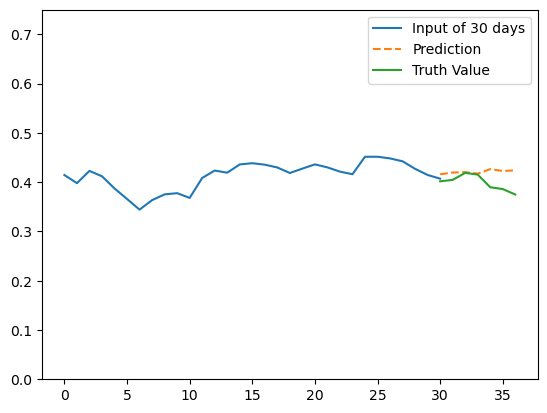

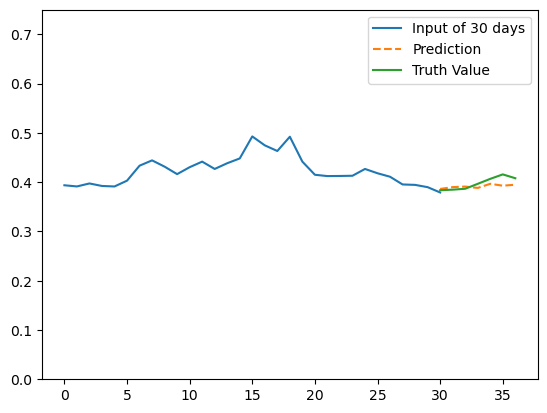

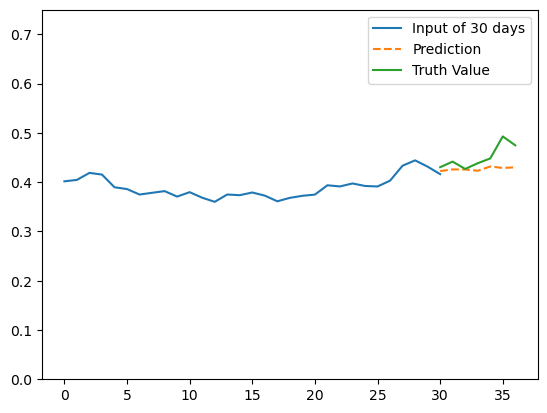

In [18]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [19]:
model.evaluate(testbatches)

      1/Unknown - 0s 43ms/step - loss: 0.0010 - mse: 0.0021

16/16 [==============================] - 0s 9ms/step - loss: 4.4255e-04 - mse: 8.8510e-04


[0.0004425519146025181, 0.0008851038292050362]

1/1 [==============================] - 0s 25ms/step


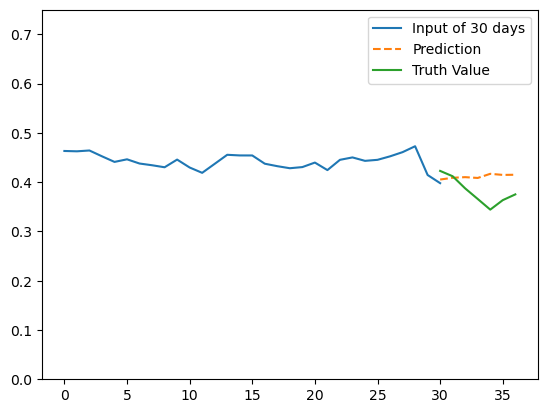

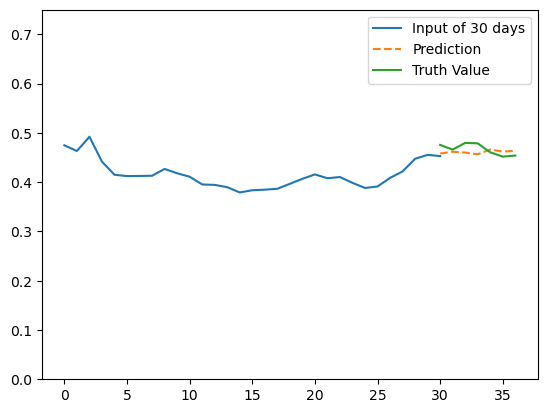

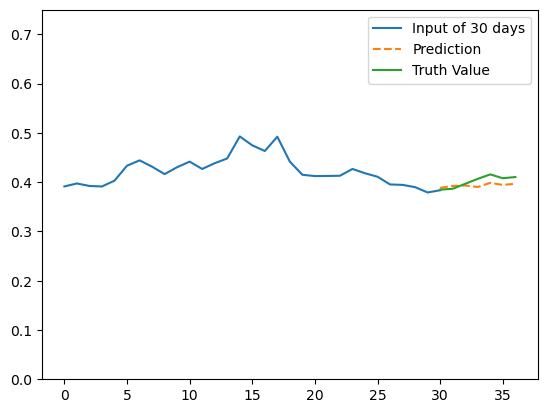

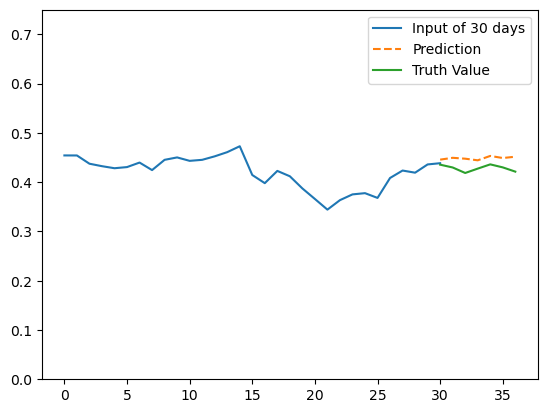

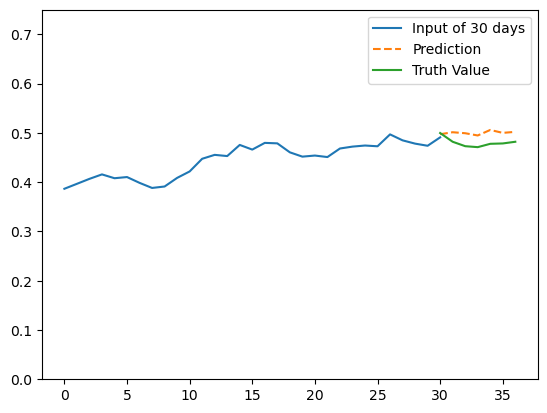

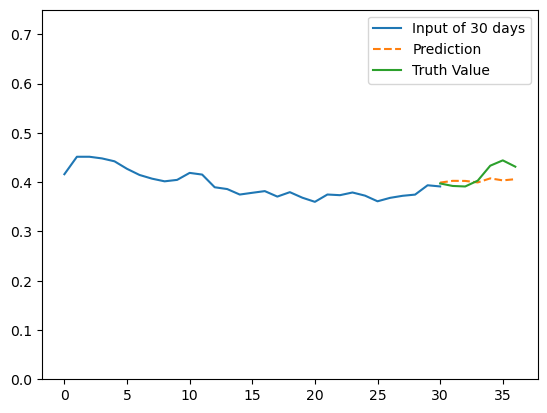

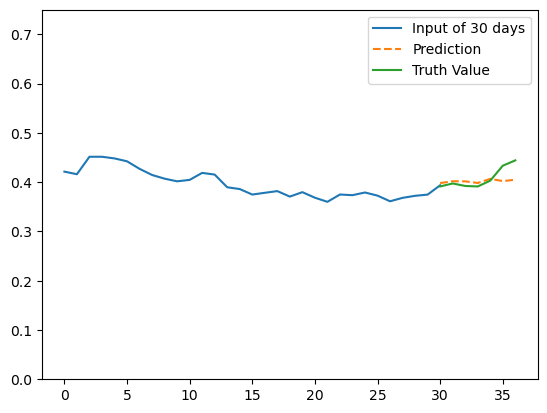

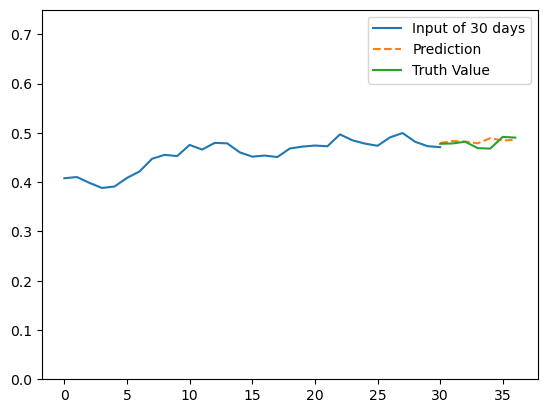

In [20]:
def visualplotloss(dataset):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(30,37))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss(testbatches)

In [21]:
df_test=yf.download('GOOGL', start='2021-07-01', end='2023-07-01')

[*********************100%%**********************]  1 of 1 completed


In [22]:
len(df_test)

503

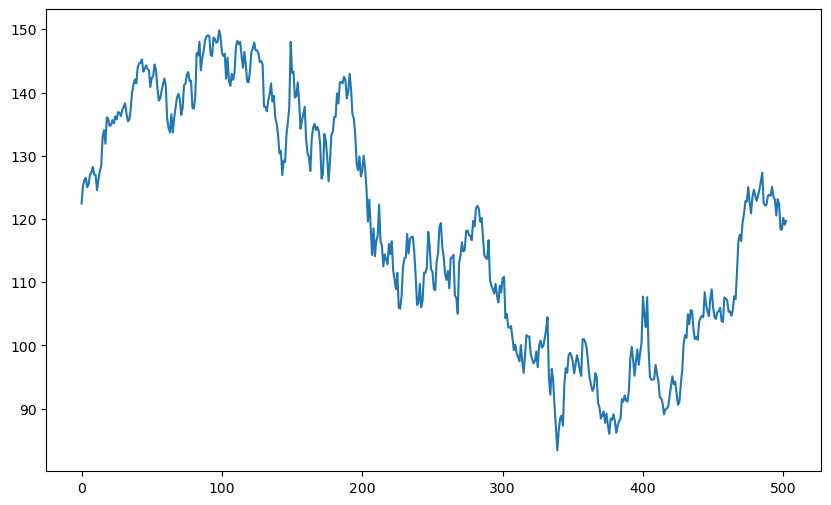

In [23]:
new_time_step=[]
for i in range(df_test.shape[0]):
    new_time_step.append(i)

close_data=df_test['Close']
new_time = np.array(new_time_step)
plt.figure(figsize=(10, 6))
plt.plot(new_time,close_data)

In [24]:
x_test=close_data
x_test=np.array(x_test).reshape(-1,1)

In [25]:
scaler1=MinMaxScaler(feature_range=(0,0.75))
xt1=scaler1.fit_transform(x_test)
xt1

array([[0.44061946],
       [0.47238869],
       [0.48292013],
       [0.48612751],
       [0.46997747],
       [0.47533637],
       [0.49179135],
       [0.49592483],
       [0.50603837],
       [0.49212446],
       [0.49172923],
       [0.46471463],
       [0.48314036],
       [0.49826833],
       [0.508122  ],
       [0.55999983],
       [0.57151949],
       [0.54740726],
       [0.59477318],
       [0.59119874],
       [0.57932908],
       [0.58077475],
       [0.58953301],
       [0.58383531],
       [0.59655196],
       [0.59075827],
       [0.60402276],
       [0.60282576],
       [0.59686267],
       [0.60719636],
       [0.61322149],
       [0.61979445],
       [0.60118243],
       [0.58748885],
       [0.59009756],
       [0.60985608],
       [0.63935531],
       [0.65313368],
       [0.66236619],
       [0.65515527],
       [0.68410667],
       [0.69073047],
       [0.69193884],
       [0.69778905],
       [0.67600911],
       [0.68111952],
       [0.68722944],
       [0.680

In [26]:
xt332=windowed_dataset(xt1)

1/1 [==============================] - 0s 33ms/step


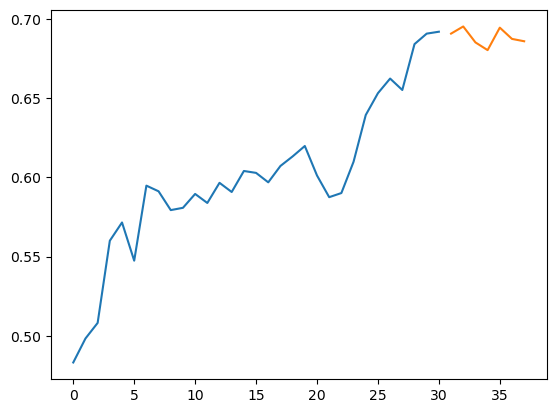

In [27]:
a,b=next(iter(xt332))
p=model.predict(a)
plt.plot(np.arange(0,31),a[0])
plt.plot(np.arange(31,38),p[0])

In [28]:
model.save('Model1_pred_7days.h5')

c:\Users\djsma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
#Model 2:
def windowed_dataset1(series, window_size = 62,predday = 14, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-14], tf.squeeze(w[-14:])))
    return ds.batch(batch_size).prefetch(3)

train2batches =  windowed_dataset1(closetrain)
test2batches =  windowed_dataset1(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(14)
np.random.seed(14)

model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model2.add(layers.LSTM(j, return_sequences=True))
model2.add(layers.LSTM(128))
for i in [64,64,14]:
    model2.add(layers.Dense(i, activation="selu"))

print(model2.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model2.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h1 = model2.fit(train2batches,epochs=20,validation_data=test2batches,verbose=1)
hist1 = h1.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 14)                9

None
Epoch 1/20
55/55 [==============================] - 13s 159ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 2/20
55/55 [==============================] - 9s 167ms/step - loss: 4.8762e-04 - mse: 9.7525e-04 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 3/20
55/55 [==============================] - 9s 171ms/step - loss: 5.6193e-04 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 4/20
55/55 [==============================] - 10s 182ms/step - loss: 5.8775e-04 - mse: 0.0012 - val_loss: 0.0016 - val_mse: 0.0031
Epoch 5/20
55/55 [==============================] - 14s 249ms/step - loss: 5.0603e-04 - mse: 0.0010 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 6/20
55/55 [==============================] - 12s 215ms/step - loss: 4.1827e-04 - mse: 8.3654e-04 - val_loss: 0.0013 - val_mse: 0.0025
Epoch 7/20
55/55 [==============================] - 11s 195ms/step - loss: 3.9084e-04 - mse: 7.8168e-04 - val_loss: 9.7287e-04 - val_mse: 0.0019
Epoch 8/20
55/55 [========

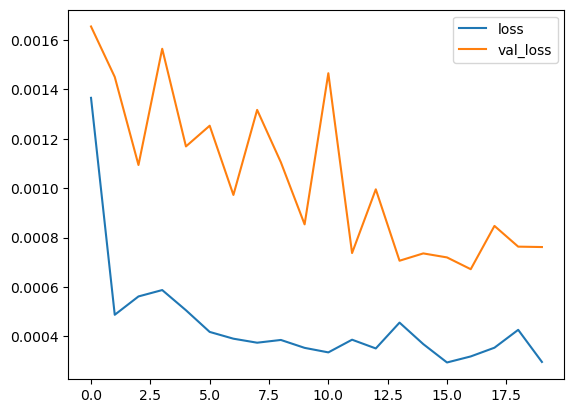

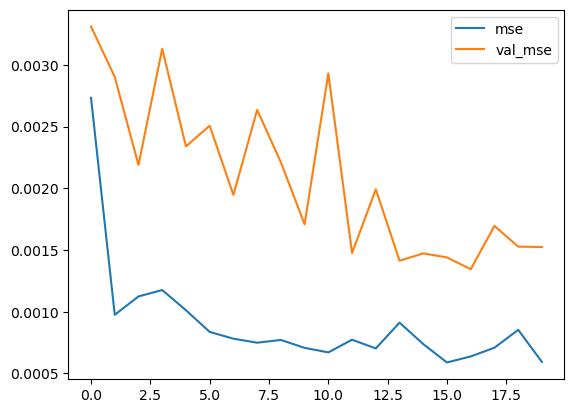

In [30]:
for i in ["loss","mse"]:
    plt.plot(hist1[i],label = i)
    plt.plot(hist1["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 711ms/step


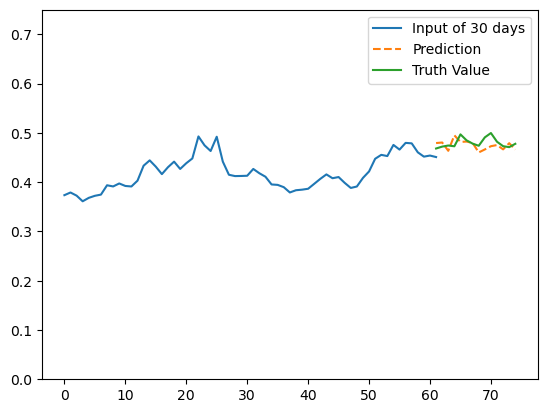

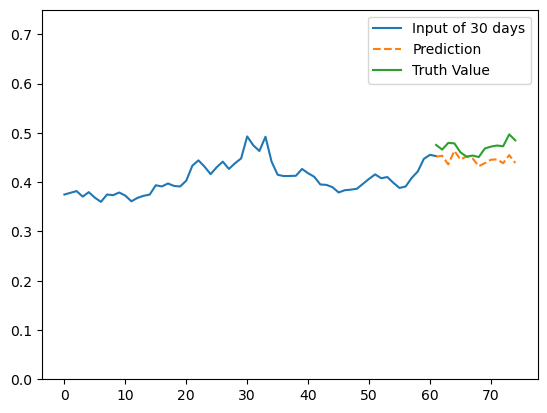

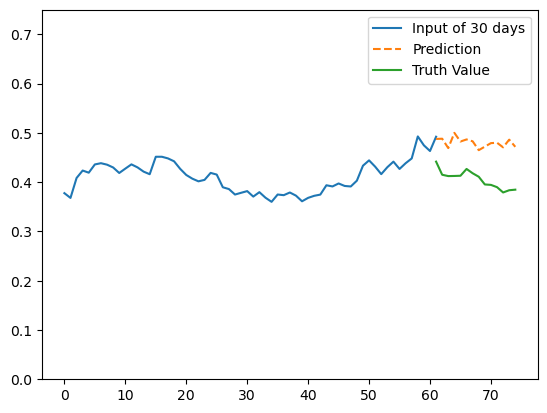

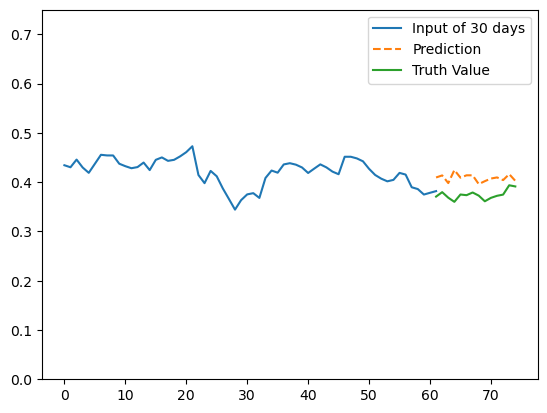

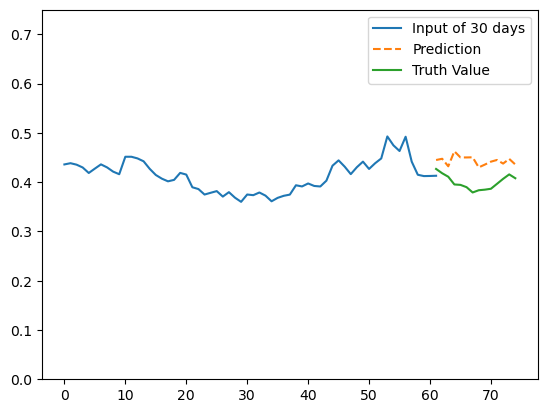

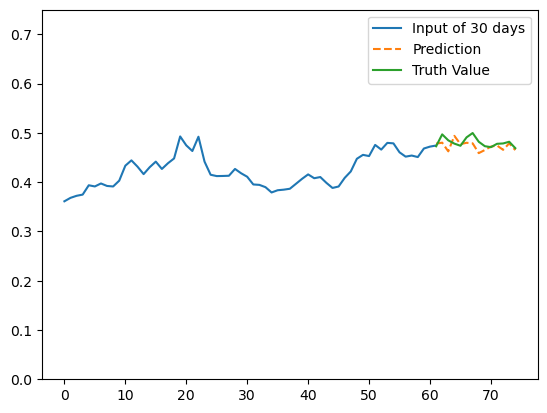

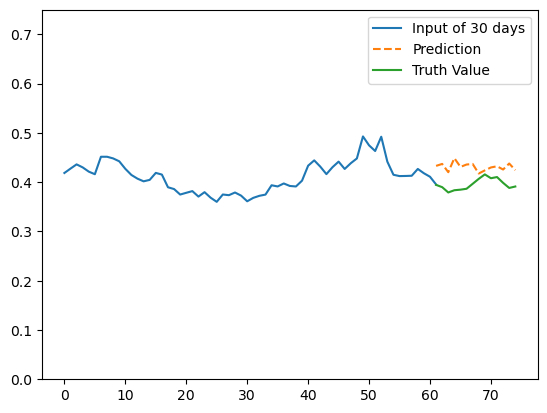

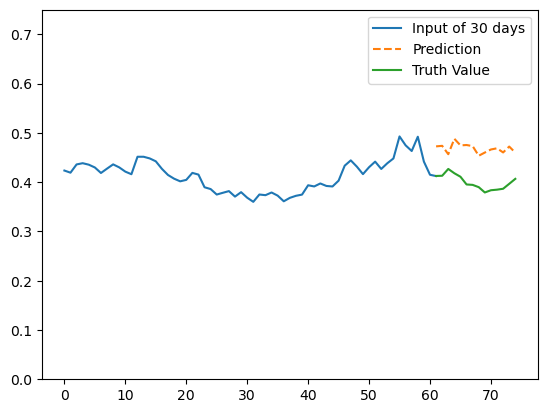

In [31]:
def visualplotloss2(dataset):
    x,y = next(iter(dataset))
    output = model2.predict(x)
    timecorr =list(range(61,75))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss2(test2batches)

1/1 [==============================] - 0s 32ms/step


Text(0.5, 1.0, 'Prediction for 14 Days')

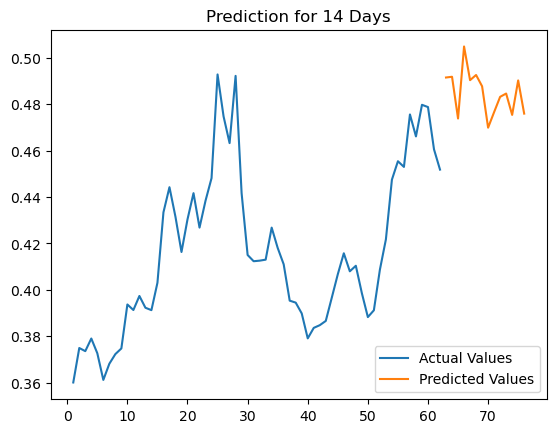

In [32]:
x2,y2 = next(iter(test2batches))
output2 = model2.predict(x2)

time=list(range(1,63))
time2=list(range(63,77))
plt.plot(time,x2[0])
plt.plot(time2,output2[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 14 Days')

In [33]:
model2.save('Model2_pred_14days.h5')

In [34]:
#Model 3:
def windowed_dataset2(series, window_size = 90,predday = 21, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-21], tf.squeeze(w[-21:])))
    return ds.batch(batch_size).prefetch(3)

train3batches =  windowed_dataset2(closetrain)
test3batches =  windowed_dataset2(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(21)
np.random.seed(21)

model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model3.add(layers.LSTM(j, return_sequences=True))
model3.add(layers.LSTM(128))
for i in [64,64,21]:
    model3.add(layers.Dense(i, activation="selu"))

print(model3.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model3.compile(optimizer = 'adam', loss ='mse', metrics=["mse"])
h2 = model3.fit(train3batches,epochs=30,validation_data=test3batches,verbose=1)
hist2 = h2.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1

None
Epoch 1/30
54/54 [==============================] - 18s 247ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/30
54/54 [==============================] - 13s 248ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/30
54/54 [==============================] - 14s 259ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/30
54/54 [==============================] - 17s 306ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/30
54/54 [==============================] - 20s 377ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/30
54/54 [==============================] - 18s 327ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 7/30
54/54 [==============================] - 19s 350ms/step - loss: 9.9744e-04 - mse: 9.9744e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/30
54/54 [==============================] - 16s 

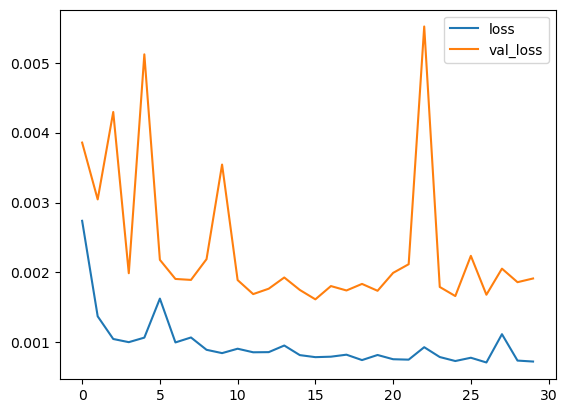

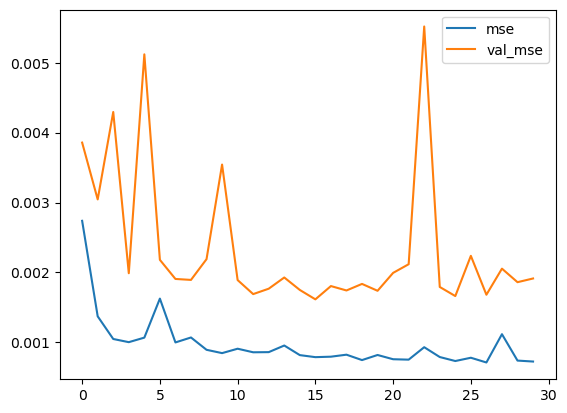

In [35]:
for i in ["loss","mse"]:
    plt.plot(hist2[i],label = i)
    plt.plot(hist2["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 718ms/step


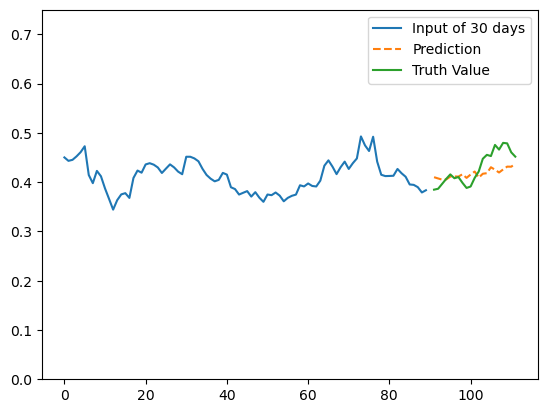

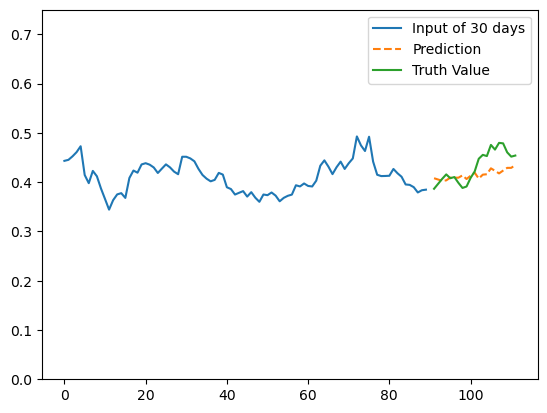

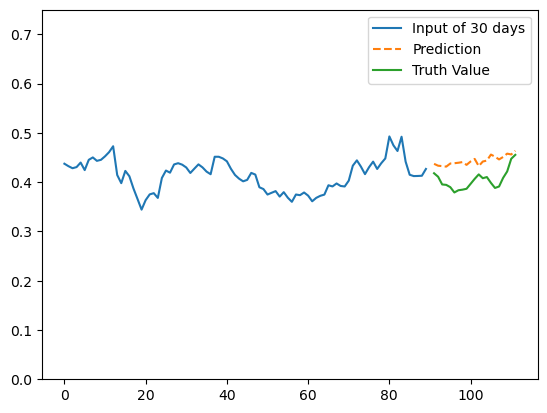

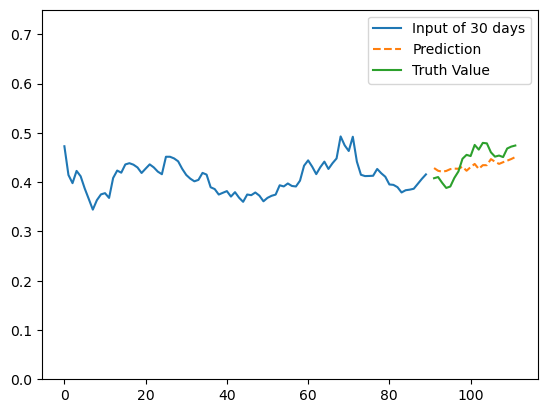

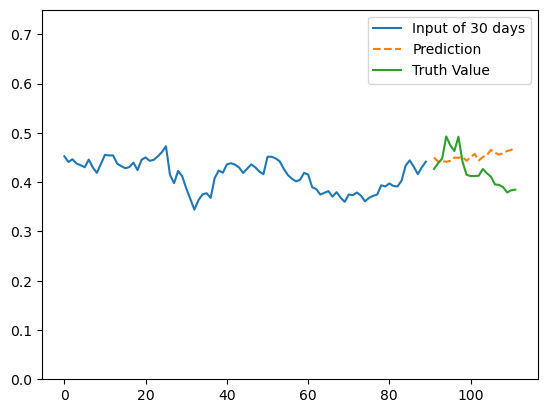

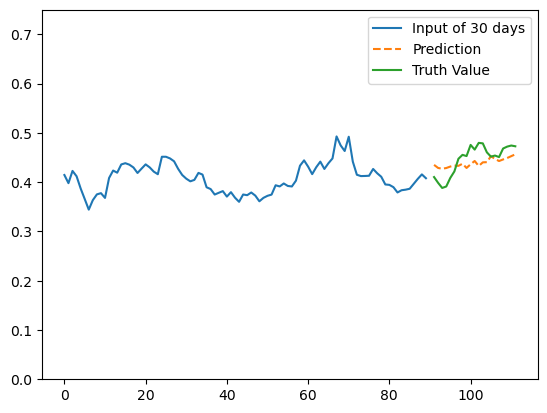

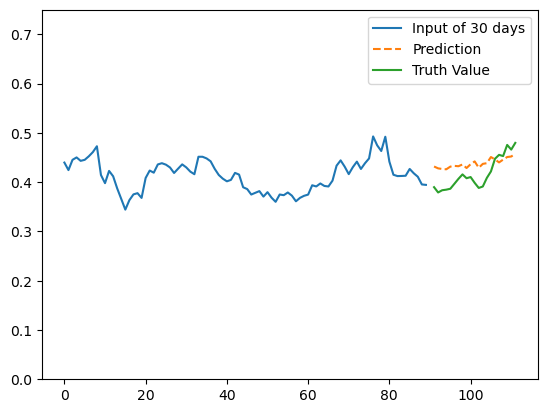

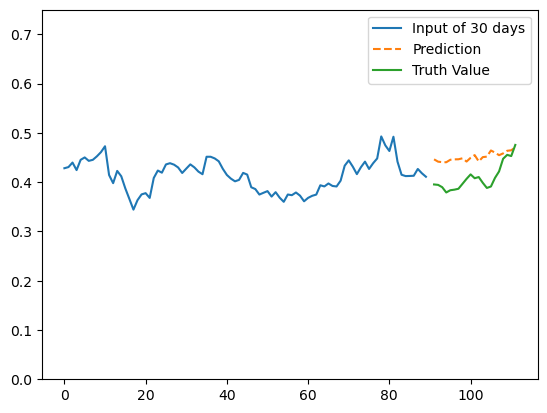

In [36]:
def visualplotloss3(dataset):
    x,y = next(iter(dataset))
    output = model3.predict(x)
    timecorr =list(range(91,112))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss3(test3batches)

1/1 [==============================] - 0s 39ms/step


Text(0.5, 1.0, 'Prediction for 21 Days')

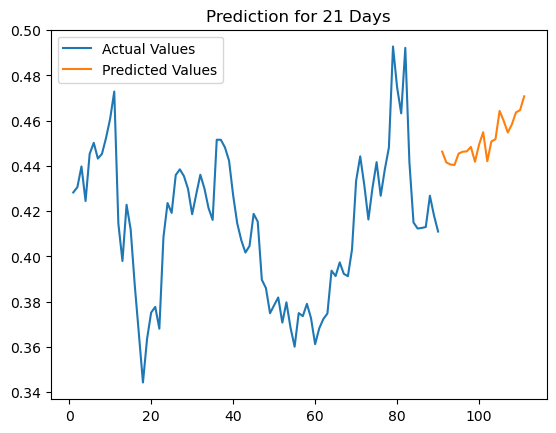

In [37]:
x3,y3 = next(iter(test3batches))
output3 = model3.predict(x3)

time=list(range(1,91))
time2=list(range(91,112))
plt.plot(time,x3[0])
plt.plot(time2,output3[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 21 Days')

In [38]:
model3.save('Model_3_Pred21_Days.h5')

In [39]:
#Model 4:
def windowed_dataset3(series, window_size = 120,predday = 28, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-28], tf.squeeze(w[-28:])))
    return ds.batch(batch_size).prefetch(3)

train4batches =  windowed_dataset3(closetrain)
test4batches =  windowed_dataset3(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(28)
np.random.seed(28)

model4 = tf.keras.Sequential()
model4.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model4.add(layers.LSTM(j, return_sequences=True))
model4.add(layers.LSTM(128))
for i in [64,64,28]:
    model4.add(layers.Dense(i, activation="selu"))

print(model4.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model4.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h3 = model4.fit(train4batches,epochs=20,validation_data=test4batches,verbose=1)
hist3 = h3.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 28)                1

None
Epoch 1/20
53/53 [==============================] - 17s 250ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 9.3802e-04 - val_mse: 0.0019
Epoch 2/20
53/53 [==============================] - 18s 334ms/step - loss: 6.5429e-04 - mse: 0.0013 - val_loss: 0.0034 - val_mse: 0.0069
Epoch 3/20
53/53 [==============================] - 19s 352ms/step - loss: 9.1191e-04 - mse: 0.0018 - val_loss: 8.2531e-04 - val_mse: 0.0017
Epoch 4/20
53/53 [==============================] - 18s 339ms/step - loss: 9.5261e-04 - mse: 0.0019 - val_loss: 0.0022 - val_mse: 0.0044
Epoch 5/20
53/53 [==============================] - 21s 388ms/step - loss: 6.0043e-04 - mse: 0.0012 - val_loss: 5.5041e-04 - val_mse: 0.0011
Epoch 6/20
53/53 [==============================] - 20s 380ms/step - loss: 7.1804e-04 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0034
Epoch 7/20
53/53 [==============================] - 18s 334ms/step - loss: 5.6844e-04 - mse: 0.0011 - val_loss: 0.0029 - val_mse: 0.0057
Epoch 8/20
53/53 [==========

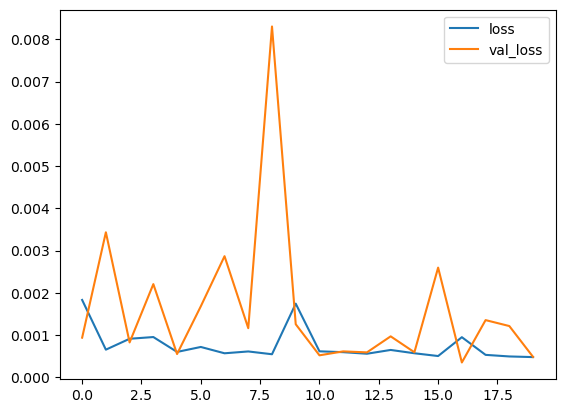

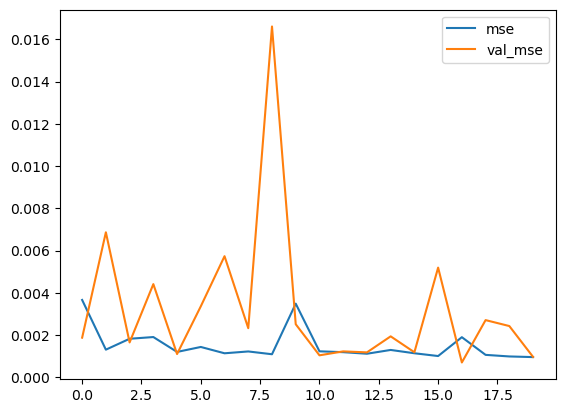

In [40]:
for i in ["loss","mse"]:
    plt.plot(hist3[i],label = i)
    plt.plot(hist3["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

1/1 [==============================] - 1s 939ms/step


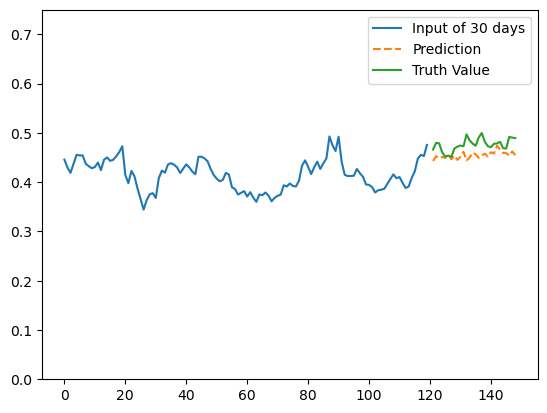

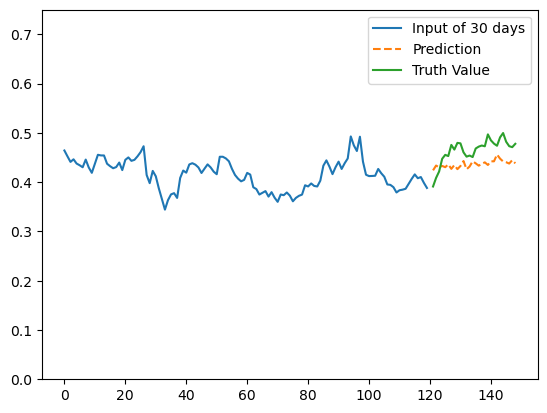

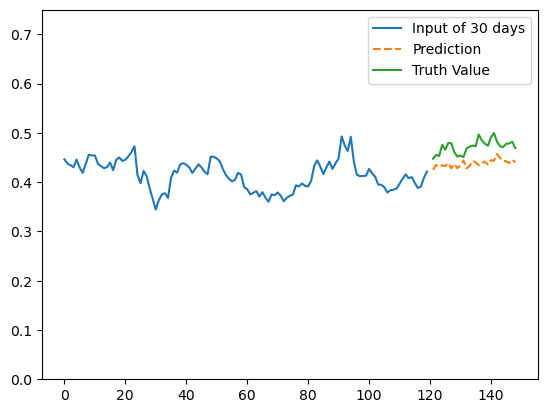

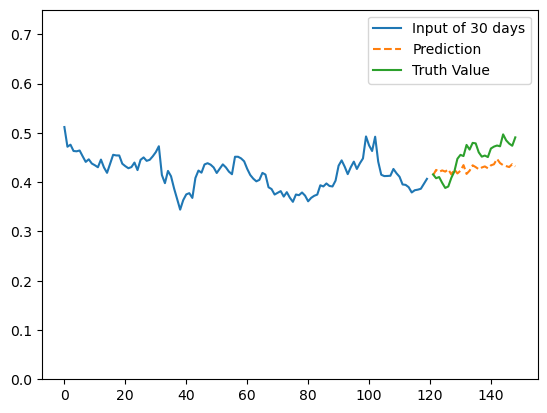

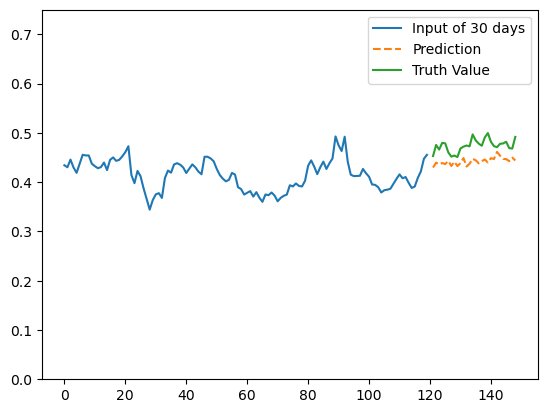

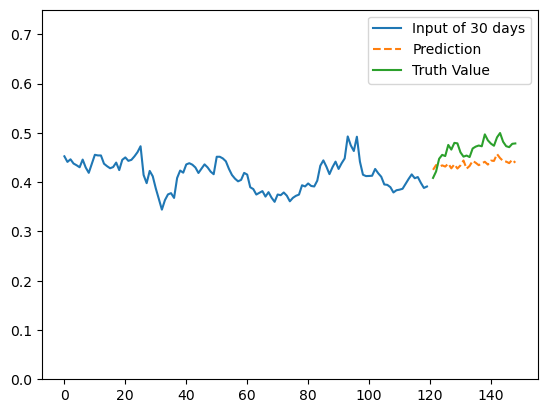

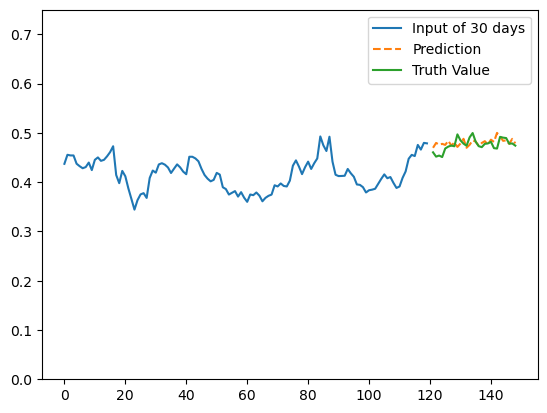

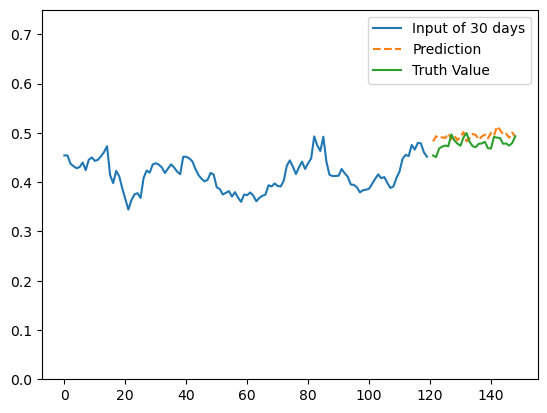

In [41]:
def visualplotloss4(dataset):
    x,y = next(iter(dataset))
    output = model4.predict(x)
    timecorr =list(range(121,149))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss4(test4batches)

1/1 [==============================] - 0s 98ms/step


Text(0.5, 1.0, 'Prediction for 28 Days')

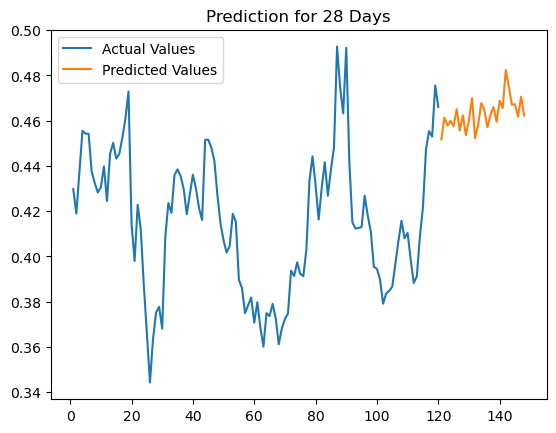

In [42]:
x4,y4 = next(iter(test4batches))
output4 = model4.predict(x4)

time=list(range(1,121))
time2=list(range(121,149))
plt.plot(time,x4[0])
plt.plot(time2,output4[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 28 Days')

In [43]:
model4.save('Model_4_Pred28_Days.h5')

In [54]:
#Model 5:
def windowed_dataset4(series, window_size = 150,predday = 35, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-35], tf.squeeze(w[-35:])))
    return ds.batch(batch_size).prefetch(3)

train5batches =  windowed_dataset4(closetrain)
test5batches =  windowed_dataset4(closetest,batch_size=8)

from tensorflow.keras import layers

tf.keras.backend.clear_session()

tf.random.set_seed(35)
np.random.seed(35)

model5 = tf.keras.Sequential()
model5.add(layers.Conv1D(128,5,1,padding = "causal",activation = "relu",input_shape=[None, 1]))
for j in [128,128]:
    model5.add(layers.LSTM(j, return_sequences=True))
model5.add(layers.LSTM(128))
for i in [64,64,35]:
    model5.add(layers.Dense(i, activation="selu"))

print(model5.summary())



optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
kl = l = tf.keras.losses.LogCosh()
model5.compile(optimizer = 'adam', loss =tf.keras.losses.Huber(), metrics=["mse"])
h4 = model5.fit(train5batches,epochs=30,validation_data=test5batches,verbose=1)
hist4 = h4.history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 35)                2

None
Epoch 1/30
51/51 [==============================] - 42s 603ms/step - loss: 0.0030 - mse: 0.0059
Epoch 2/30
51/51 [==============================] - 31s 598ms/step - loss: 8.3349e-04 - mse: 0.0017
Epoch 3/30
51/51 [==============================] - 33s 649ms/step - loss: 8.2471e-04 - mse: 0.0016
Epoch 4/30
51/51 [==============================] - 32s 611ms/step - loss: 7.5630e-04 - mse: 0.0015
Epoch 5/30
51/51 [==============================] - 30s 583ms/step - loss: 7.5909e-04 - mse: 0.0015
Epoch 6/30
51/51 [==============================] - 30s 579ms/step - loss: 6.8015e-04 - mse: 0.0014
Epoch 7/30
51/51 [==============================] - 23s 453ms/step - loss: 7.4640e-04 - mse: 0.0015
Epoch 8/30
51/51 [==============================] - 23s 448ms/step - loss: 6.9702e-04 - mse: 0.0014
Epoch 9/30
51/51 [==============================] - 23s 448ms/step - loss: 7.2020e-04 - mse: 0.0014
Epoch 10/30
51/51 [==============================] - 25s 489ms/step - loss: 7.2838e-04 - mse: 0.001

KeyError: 'val_loss'

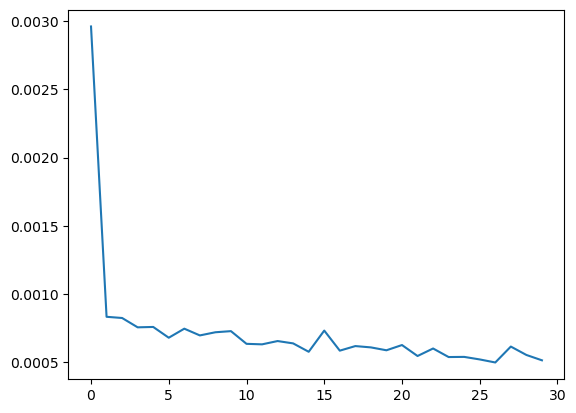

In [55]:
for i in ["loss","mse"]:
    plt.plot(hist4[i],label = i)
    plt.plot(hist4["val_"+i],label = "val_"+i)
    plt.legend()
    plt.show()

In [51]:
def visualplotloss5(dataset):
    x,y = next(iter(dataset))
    output = model5.predict(x)
    timecorr =list(range(151,186))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

visualplotloss5(test5batches)

StopIteration: 

In [48]:
x5,y5 = next(iter(test5batches))
output5 = model5.predict(x5)

time=list(range(1,151))
time2=list(range(151,186))
plt.plot(time,x5[0])
plt.plot(time2,output5[0])
plt.legend(['Actual Values','Predicted Values'])
plt.title('Prediction for 35 Days')

StopIteration: 

In [ ]:
model5.save('Model5_Pred_35Days.h5')